In [4]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import numpy as np

Outside sources: [Pytorch Tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare Data

In [6]:
def image_loader(image_name, im_size=512):
  image = Image.open(image_name)
  loader = transforms.Compose([
  transforms.Resize(im_size),  
  transforms.ToTensor()])

  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

def imshow(tensor, name=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0) 
    unloader = transforms.ToPILImage()   
    image = unloader(image)
    plt.axis("off")
    plt.imshow(image)
    if name is not None:
      plt.savefig(name, dpi=200)
    plt.pause(0.001)


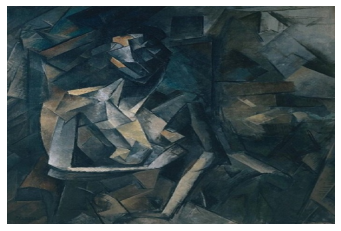

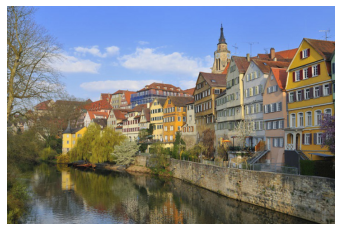

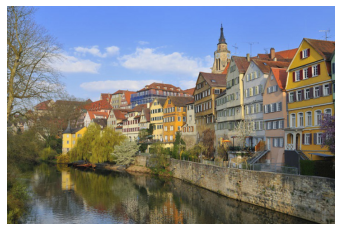

In [7]:
style_img = image_loader("picasso2.jpg")
content_img = image_loader("neckarfront.jpg")
input_img = content_img.clone()

plt.figure()
imshow(style_img)
imshow(content_img)
imshow(input_img)

## Get Model and Losses

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d) 
    G = torch.mm(features, features.t()) 
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [10]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [11]:
content_layers_default =  ['conv_10']
#style_layers_default = ['conv_3', 'conv_5', 'conv_9', 'conv_15', 'conv_16']
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

def build_model_loss(vgg, style_img, content_img, content_layers=content_layers_default,
                               style_layers=style_layers_default):
    vgg = copy.deepcopy(vgg)
    normalization = Normalization().to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for index, layer in enumerate(vgg.children()):
        print(layer)
        name = None
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)

        model.add_module(str(index), layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            print(model[-1])
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            print(model[-1])
            style_losses.append(style_loss)

    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break

    model = model[:(j + 1)]

    return model, style_losses, content_losses

## Train CNN

In [12]:
def style_transfer(vgg, content_img, style_img, input_img, num_steps,
                       style_weight, content_weight):
  
    model, style_losses, content_losses = build_model_loss(vgg, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('--------------STYLE TRANSFER-------------')
    step = [0]
    while step[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward(retain_graph=True)

            step[0] += 1
            if step[0] % 300 == 0:
                print("step {}:".format(step[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                input_img.data.clamp_(0, 1)
                imshow(input_img)

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
StyleLoss()
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


StyleLoss()
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
StyleLoss()
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
StyleLoss()
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ContentLoss()
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

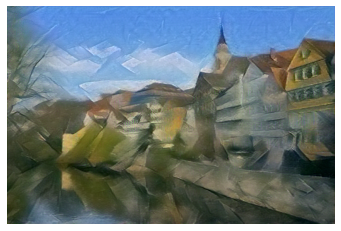

step 600:
Style Loss : 125.426537 Content Loss: 31.927322



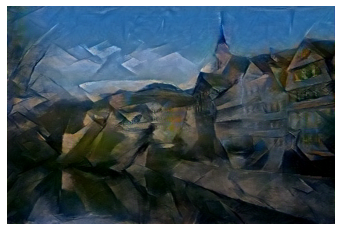

step 900:
Style Loss : 21.340878 Content Loss: 29.925442



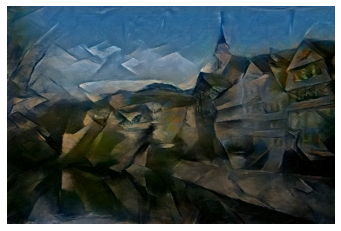

step 1200:
Style Loss : 15.276495 Content Loss: 28.715771



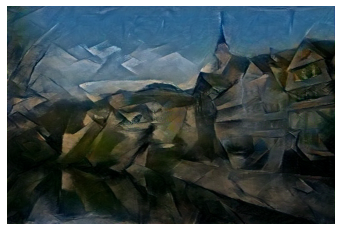

step 1500:
Style Loss : 12.138674 Content Loss: 28.009853



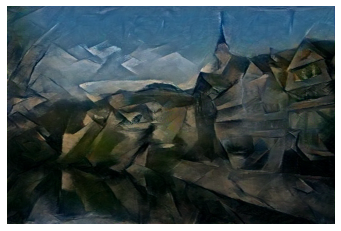

step 1800:
Style Loss : 10.447268 Content Loss: 27.588797



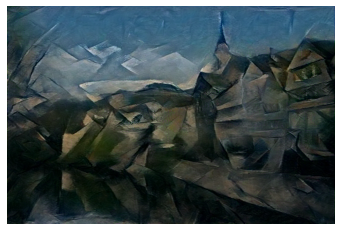

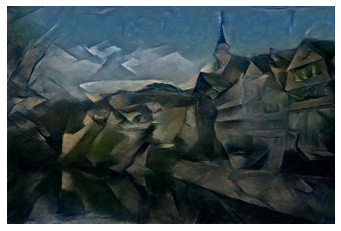

In [13]:
NUM_STEPS = 2000
STYLE_WEIGHT = 1000000000
CONTENT_WEIGHT = 1

output = style_transfer(vgg, content_img, style_img, input_img, NUM_STEPS, STYLE_WEIGHT, CONTENT_WEIGHT)

plt.figure()
imshow(output)

plt.show()

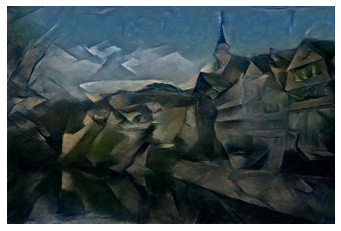

In [14]:
imshow(output, name="the_scream_transfered.jpg")